In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from scipy.constants import N_A
from scipy import linalg
import math, cmath


In [79]:
Target_cell_number = 2e5
well_size = 150e-6
t_end = 60*60*10
t = np.geomspace(1e-8, t_end, 1000)
tspan = [1e-8, t_end]
z0 = [0, 0]
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)



In [38]:
def model_S_monospecific(t, z, Ainit, rtot, kon, k2, koff):
     k = Ainit*kon
     Atot = well_size*N_A*Ainit/Target_cell_number
     A0 = Atot - z[0] - z[1] 
     Ag = rtot - z[0] - 2*z[1]

     dA10 = 2*(k*Ag*A0/Atot) - koff*z[0] - (k2*Ag*z[0]) + 2*koff*z[1]
     dA11 = (k2*Ag*z[0]) - 2*koff*z[1]

     return [dA10, dA11]

def model_S_dimensionless(t, z, alpha1, alpha2, beta):

     A0 = beta - z[0] - z[1] 
     Ag = 1 - z[0] - 2*z[1]

     dA10 = 2*(alpha1*Ag*A0) - z[0] - (alpha2*Ag*z[0]) + 2*z[1]
     dA11 = (alpha2*Ag*z[0]) - 2*z[1]

     return [dA10, dA11]



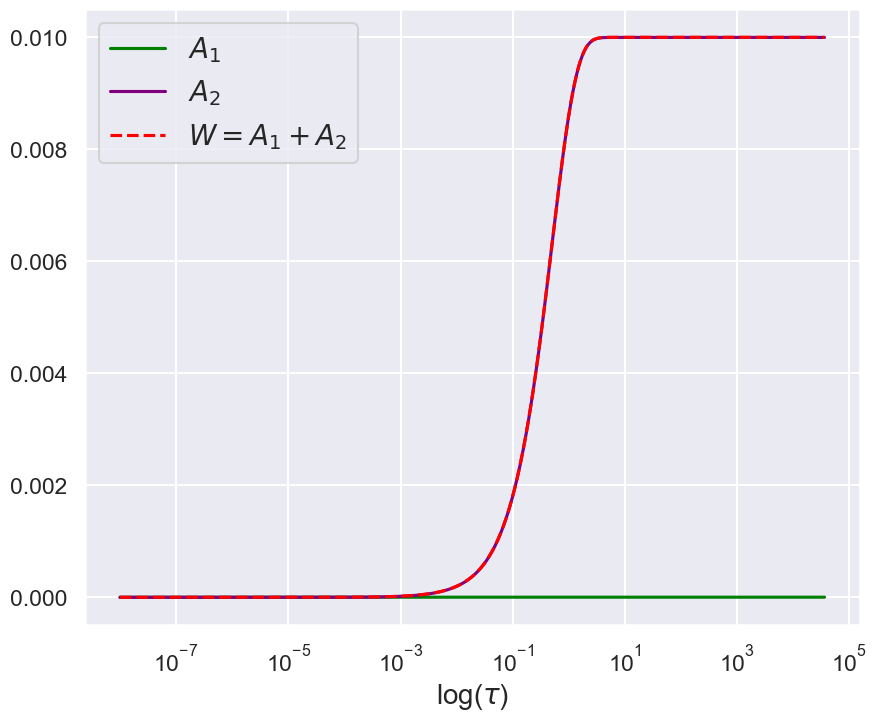

In [80]:
sns.set_theme()
sns.set_context('talk')
z = solve_ivp(model_S_dimensionless, tspan, z0, method='Radau', t_eval=t, args = (1, 1e4, 1e-2))
A1 = z.y[0]
A2 = z.y[1]
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(t, A1, c='green', label=r'$A_1$')
ax.plot(t, A2, c='purple', label=r'$A_2$')
ax.plot(t, A1 + A2, c='red', label=r'$W=A_1+A_2$', linestyle='dashed')
ax.set_xscale('log')
ax.legend(loc='best', fontsize=20)
ax.set_xlabel(r'log($\tau$)', fontsize=20)
plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/sim_beta_1e-2.png')

In [40]:
sigma = well_size*N_A/Target_cell_number

def A1_steady_state(x, Ainit, k1, koff, k2, rtot):
    k1 = k1/sigma
    Atot = well_size*N_A*Ainit/Target_cell_number
    express = 2*k1*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x))))*(Atot - x - (k2*x*(rtot-x)/(2*(koff + k2*x)))) -koff*x - k2*x*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x)))) +2*koff*(k2*x*(rtot-x)/(2*(koff + k2*x)))

    return express

def A2_steady_state(x, k2, koff, rtot):
    express = k2*x*(rtot-x)/(2*(koff + k2*x))

    return express

def A1_steady_state_dimensionless(x, Ainit, rtot, alpha1, alpha2):
    Atot = sigma*Ainit
    beta = Atot/rtot
    f0 = 2*alpha1*beta
    f1 = alpha1*(2*beta*alpha2 - 2 - 2*alpha2 - 2*beta) -1
    f2 = alpha1*(2 - 2*beta*alpha2) - 2*alpha2
    f3 = alpha1*alpha2 - (alpha2**2)

    return f3*(x**3) + f2*(x**2) + f1*x + f0

def A2_steady_state_dimensionless(A1, alpha2):

    return(alpha2*A1*(1-A1))/(2*(1 + alpha2*A1))

"""
def A1_steady_state(x, Ainit, k1, koff, k2, rtot):
    k1 = k1/sigma
    Atot = well_size*N_A*Ainit/Target_cell_number
    express = 2*k1*((rtot*Atot -rtot*x - Atot*x + (x**2))*((2*(koff + k2*x))**2) + 6*x*(k2*x*(rtot-x)*(koff + k2*x)) - 
                    4*Atot*k2*x*(rtot-x)*(koff +k2*x) + 2*((k2*x*(rtot-x))**2)) -koff*x* ((2*(koff + k2*x))**2) -k2*x*((rtot-x)*((2*(koff + k2*x))**2) 
                    - 4*k2*x*(rtot-x)*(koff + k2*x)) + 4*koff*k2*x*(rtot-x)*(koff + k2*x)
    
    return express
"""


'\ndef A1_steady_state(x, Ainit, k1, koff, k2, rtot):\n    k1 = k1/sigma\n    Atot = well_size*N_A*Ainit/Target_cell_number\n    express = 2*k1*((rtot*Atot -rtot*x - Atot*x + (x**2))*((2*(koff + k2*x))**2) + 6*x*(k2*x*(rtot-x)*(koff + k2*x)) - \n                    4*Atot*k2*x*(rtot-x)*(koff +k2*x) + 2*((k2*x*(rtot-x))**2)) -koff*x* ((2*(koff + k2*x))**2) -k2*x*((rtot-x)*((2*(koff + k2*x))**2) \n                    - 4*k2*x*(rtot-x)*(koff + k2*x)) + 4*koff*k2*x*(rtot-x)*(koff + k2*x)\n    \n    return express\n'

In [41]:
A0s = np.geomspace(1e-12, 1e-5, 1000)

A1_st_sim = np.zeros_like(A0s)
A1_st_root = np.zeros_like(A0s)
A2_st_sim = np.zeros_like(A0s)
A2_st_root = np.zeros_like(A0s)

D = 1e-14
k2 = 4*D/tumour_cell_surface_area
rtot = 1e6
r_ab = 1.25e-8
kon = 1e5
koff = 1e-4
alpha1 = kon*rtot/(koff*sigma)
alpha2 = k2*rtot/koff
"""
reaction_volume = (2*math.pi*(r_ab**3))/3
target_effective_conc =(rtot)*(tumour_cell_surface_area)*(1/N_A)/(reaction_volume)
k2 = target_effective_conc*kon
alpha2 = k2/koff
"""
for i, Ainit in enumerate(A0s):

    A1_st_root[i] = fsolve(A1_steady_state_dimensionless, [1], args=(Ainit, rtot, alpha1, alpha2))
    A2_st_root[i] = A2_steady_state_dimensionless(A1_st_root[i], alpha2)
    """
    A1_st_root[i] = fsolve(A1_steady_state, [0], args=(Ainit, 1e5, 1e-2, k2, 1e7))
    A2_st_root[i] = A2_steady_state(A1_st_root[i], k2, 1e-2, 1e7)
    z = solve_ivp(model_S_monospecific, tspan, z0, method='Radau', t_eval=t, args=(Ainit, 1e7, 1e5, k2, 1e-2))
    A1 = z.y[0]
    A2 = z.y[1]
    A1_st_sim[i] = A1[-1]
    A2_st_sim[i] = A2[-1]
    """


In [42]:
r_ab = 1.25e-8
reaction_volume = ((2*math.pi*(r_ab**3))/3)*(1000)
reaction_area = math.pi*(r_ab**2)
(1e4*reaction_area/tumour_cell_surface_area)*(1/N_A)*(1/reaction_volume)


2.477653131918024e-06

In [43]:
reaction_volume = (2*math.pi*(r_ab**3))/3
reaction_area = math.pi*(r_ab**2)
target_effective_conc =(rtot)*(reaction_area/tumour_cell_surface_area)*(1/N_A)/(reaction_volume)
target_effective_conc1 =(rtot)*(tumour_cell_surface_area)*(1/N_A)/(reaction_volume)
print(target_effective_conc, target_effective_conc1)

0.24776531319180237 0.00032647526491891564


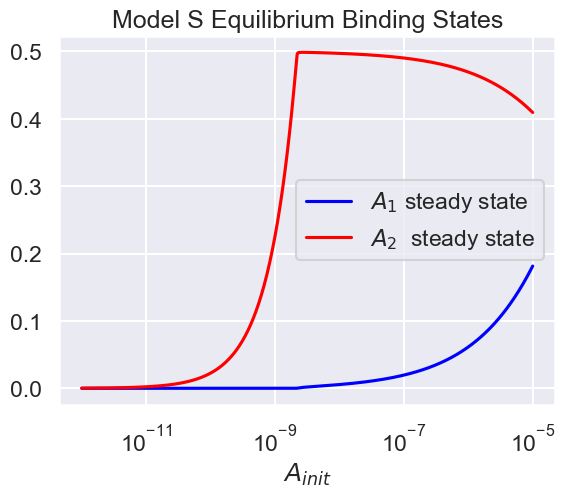

In [44]:
sns.set_theme()
sns.set_context('talk')
plt.plot(A0s, A1_st_root, label = r'$A_1$' + ' steady state', color='blue')
#plt.plot(A0s, A1_st_root, label = 'A1 calculated root')
plt.plot(A0s, A2_st_root, label = r'$A_2$ ' + ' steady state', color='red')
#plt.plot(A0s, A2_st_root, label = 'A2 calculated root')

plt.title('Model S Equilibrium Binding States')
plt.xscale('log')
plt.legend(loc='best')
plt.xlabel(r'$A_{init}$')
plt.show()

0.2214052089565129


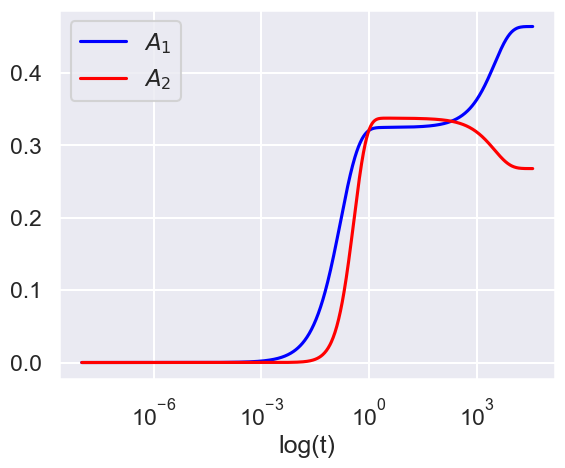

In [45]:
print((1e5/sigma)*1e5/1e-4)
z = solve_ivp(model_S_monospecific, tspan, z0, method='Radau', t_eval=t, args=(1e-5, 1e5, 1e5, k2, 1e-4))
plt.plot(t, z.y[0]/1e5, label=r'$A_1$', c='blue')
plt.plot(t, z.y[1]/1e5, label = r'$A_2$', c='red')
plt.legend(loc='best')
plt.xlabel('log(t)')
plt.xscale('log')
plt.show()

In [46]:
print(1e-5*sigma/1e5)

45166.0557


In [47]:
def A2_nullcline1(A2, alpha2):
    a = 1
    b = 2*A2 -1 
    c = (2/alpha2)
    express = (-b + np.sqrt((b)**2 - 4*a*c))/(2*a)

    return express

def A2_nullcline2(A2, alpha2):
    a = 1
    b = 2*A2 -1 
    c = (2/alpha2)
    express = (-b - np.sqrt((b)**2 - 4*a*c))/(2*a)

    return express

def A1_nullcline1(A2, alpha1, alpha2, beta):
    a = (2*alpha1 + alpha2)
    b = (2*alpha1)*(3*A2 - beta - 1)  -1 -alpha2*(1+2*A2)
    c = 2*alpha1*(beta*(1- 2*A2) - A2 + 2*((A2)**2)) + 2*A2
    express = (-b - np.sqrt((b)**2 - 4*a*c))/(2*a)

    return express

def A1_nullcline2(A2, alpha1, alpha2, beta):
    a = (2*alpha1 + alpha2)
    b = (2*alpha1)*(3*A2 - beta - 1)  -1 -alpha2*(1+2*A2)
    c = 2*alpha1*(beta*(1- 2*A2) - A2 + 2*((A2)**2)) + 2*A2
    express = (-b + np.sqrt((b)**2 - 4*a*c))/(2*a)

    return express



In [48]:
def A2_nullcline(x, alpha2):

    return (alpha2*x*(1-x))/(2*(1+ x*alpha2))

def A1_nullcline1(A1, alpha1, alpha2, beta):
    a = (4*alpha1)
    b = (2*alpha1)*(3*A1 - 2*beta - 1)  + 2 + 2*alpha2*A1
    c = 2*alpha1*(beta - A1 - A1*beta + ((A1)**2)) - A1 -alpha2*A1*(1-A1)
    express = (-b - np.sqrt((b)**2 - 4*a*c))/(2*a)

    return express

def A1_nullcline2(A1, alpha1, alpha2, beta):
    a = (4*alpha1)
    b = (2*alpha1)*(3*A1 - 2*beta - 1)  + 2 + 2*alpha2*A1
    c = 2*alpha1*(beta - A1 - A1*beta + ((A1)**2)) - A1 -alpha2*A1*(1-A1)
    express = (-b + np.sqrt((b)**2 - 4*a*c))/(2*a)

    return express

0.2214052089565129
4973.5919716217295
451.66055700000004


/var/folders/fj/3c6fc0c93lg7p91tnylb8zj80000gn/T/ipykernel_58033/4036392180.py:9: RuntimeWarning: invalid value encountered in sqrt
  express = (-b - np.sqrt((b)**2 - 4*a*c))/(2*a)
/var/folders/fj/3c6fc0c93lg7p91tnylb8zj80000gn/T/ipykernel_58033/4036392180.py:17: RuntimeWarning: invalid value encountered in sqrt
  express = (-b + np.sqrt((b)**2 - 4*a*c))/(2*a)


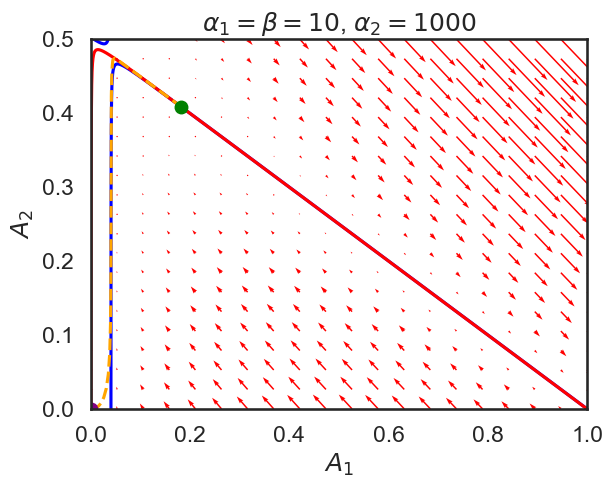

In [49]:
sns.set_theme(style = "white")
sns.set_context("talk")

kon = 1e5
rtot = 1e5
x1 = np.linspace(0, 1, 50000)
x2 = np.linspace(0, 1/2, 500)
D = 1e-15
k2 = 4*D/tumour_cell_surface_area
koff = 1e-4
Ainit = 1e-7
Atot = well_size*N_A*Ainit/Target_cell_number
t_end = 60*60*10*1000000000
t = np.geomspace(1e-10, t_end, 150)
tspan = [1e-10, t_end]

sigma = well_size*N_A/Target_cell_number
alpha1 = kon*rtot/(sigma*koff)
print(alpha1)
alpha2 = k2*rtot/koff
print(alpha2)
beta = Atot/rtot
print(beta)
#alpha1 = 100
#alpha2 = 10
#beta = 100

t1 = 0

z = solve_ivp(model_S_dimensionless, tspan, z0, method='Radau', t_eval=t, args=(alpha1, alpha2, beta))
y1 = np.linspace(0, 1, 20)
y2 = np.linspace(0, 0.5, 20)

Y1, Y2 = np.meshgrid(y1, y2)

A1, A2 = np.zeros(Y1.shape), np.zeros(Y2.shape)

Ni, Nj = Y1.shape

for i in range(Ni):
    for j in range(Nj):
        x = Y1[i, j]
        y = Y2[i, j]
        yprime = model_S_dimensionless(t1, [x, y], alpha1, alpha2, beta)
        A1[i, j] = yprime[0]
        A2[i, j] = yprime[1]

plt.plot(x1, A1_nullcline1(x1, alpha1, alpha2, beta),  c='blue', label='A1 nullcline')
plt.plot(x1, A1_nullcline2(x1, alpha1, alpha2, beta), c= 'blue')#, label='null 3')
plt.plot(x1, A2_nullcline(x1, alpha2),  c='red', label='A1 nullcline')
Q = plt.quiver(Y1, Y2, A1, A2, color='red')
z1 = z.y[0]
z2 = z.y[1]
plt.plot(z1, z2, '--', label='trajectory', c='orange')
plt.plot([z1[0]], [z2[0]], 'o', c = 'purple',label='initial condition')
plt.plot([z1[-1]], [z2[-1]], 'o', c='green', label='equilibrium')

#f = A2_steady_state(x1, alpha2)
#g = A2_alternative_null_minus(x2, alpha1, alpha2, beta)



#plt.legend(loc='best')


plt.xlim(0, 1)
plt.ylim(0, 0.5)
plt.xlabel(r'$A_1$')
plt.title(r'$\alpha_1 = \beta = 10$' + r', $\alpha_2=1000$')
plt.ylabel(r'$A_2$')
#sns.despine()
plt.show()


In [50]:
A0s = np.geomspace(1e-12, 1e-5, 300)
alpha1s = np.geomspace(1e-3, 1e2, 300)
alpha2s = np.geomspace(1e2, 1e7, 300)
k1s = np.geomspace(1e4, 1e6, 50)
r_abs = np.linspace(1e-8, 5e-8, 50)
rtots = np.geomspace(1e4, 1e6, 300)
rtot = 1e5
kon = 1e5
koff = 1e-4
sigma = well_size*N_A/Target_cell_number

r_ab = 1.25e-8
r_cell = 8e-6
Target_cell_number = 2e5
reaction_volume = (2*math.pi/3)*(r_ab**3)
Ageff = (1/reaction_volume)*(rtot/N_A)*((4*math.pi*r_ab)**2)
assay_volume = 150e-6
D = 1e-14
k2 = 4*D/tumour_cell_surface_area
alpha1 = kon*rtot/(sigma*koff)
#k2 = kon*Ageff

k1 = 1e5

Y = np.zeros((len(alpha1s), len(alpha2s)))
Y1 = np.zeros((len(alpha1s), len(alpha2s)))

for i, rtot in enumerate(rtots):
    alpha2 = k2*rtot/koff
    alpha1 = kon*rtot/(sigma*koff)
    for j, Ainit in enumerate(A0s):
        

        A1 = fsolve(A1_steady_state_dimensionless, [1], args=(Ainit, rtot, alpha1, alpha2))
        Y[i, j] = A1
        Y1[i, j] = A2_st_root[i] = A2_steady_state_dimensionless(A1, alpha2)


[  10000.           10155.21127635   10312.83160672   10472.89838236
   10635.44957486   10800.52374516   10968.16005273   11138.39826483
   11311.27876594   11486.84256738   11665.13131698   11846.18730903
   12030.05349423   12216.77348997   12406.39159059   12598.95277795
   12794.50273208   12993.087842     13194.75521677   13399.55269659
   13607.52886424   13818.73305654   14033.21537605   14251.02670303
   14472.21870741   14696.84386112   14924.95545052   15156.60758901
   15391.8552299    15630.75417946   15873.3611101    16119.73357388
   16369.93001612   16624.00978927   16882.033167     17144.06135852
   17410.15652304   17680.38178457   17954.80124688   18233.48000868
   18516.48417912   18803.88089341   19095.73832878   19392.12572066
   19693.11337907   19998.77270535   20309.17620905   20624.39752514
   20944.51143151   21269.59386669   21599.72194783   21934.97398905
   22275.42952      22621.16930469   22972.27536071   23328.83097864
   23690.92074183   24058.63054644

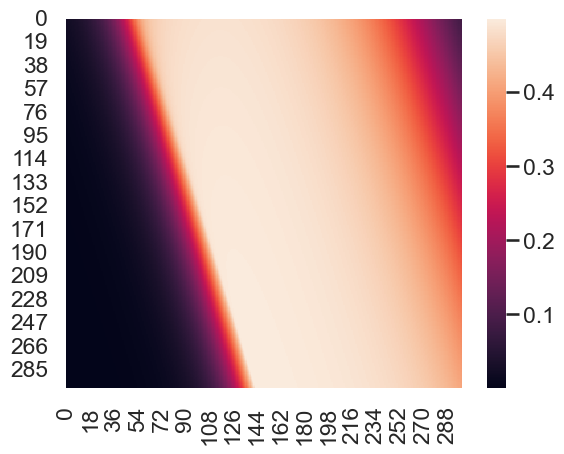

In [51]:
sns.heatmap(Y1)
print(rtots)

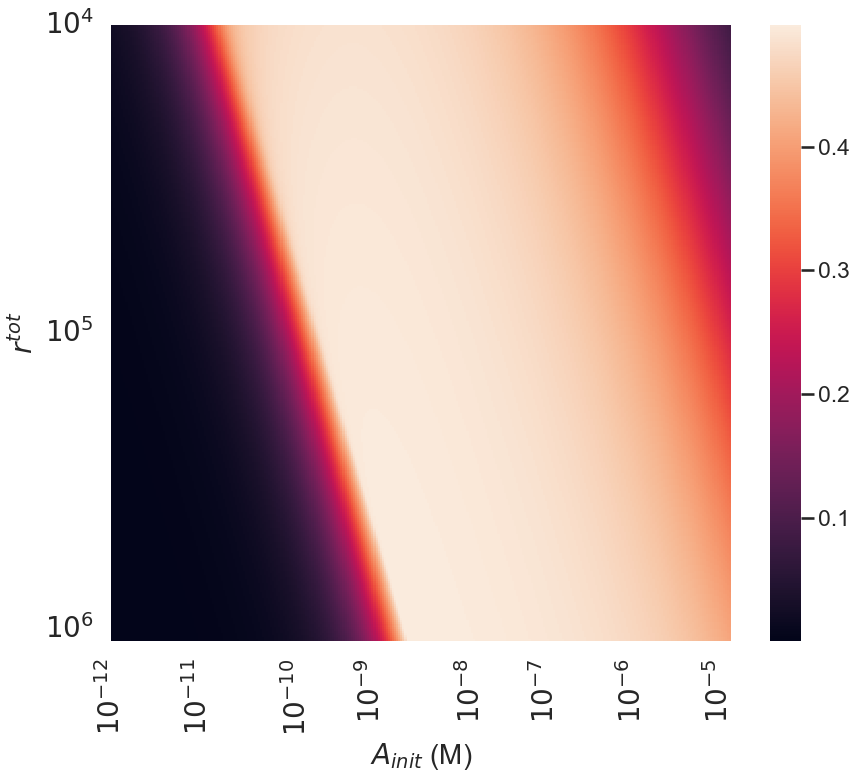

In [71]:
fig, ax = plt.subplots(figsize=(10, 8))
line = sns.heatmap(Y1, xticklabels=True, yticklabels=True, ax=ax) 
#ax = sns.heatmap(Y[0,:,:], xticklabels=True, yticklabels=True, ax=ax)
ax.set_xticks([0, 7*6, 15*6, 21*6, 29*6, 35*6, 42*6, 49*6])
ax.set_yticks([0, 25*6, 49*6])
#ax.set_yticklabels([10, r'$10^2$', r'$10^3$', r'$10^4$', r'$10^5$'])
ax.set_yticklabels([r'$10^{4}$', r'$10^{5}$', r'$10^{6}$'], fontsize=20)
ax.set_xticklabels([r'$10^{-12}$', r'$10^{-11}$', r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$'], fontsize=20)
ax.set_xlabel(r'$A_{init}$' + ' (M)', fontsize=20)
ax.set_ylabel(r'$r^{tot}$', fontsize=20)
plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/S_rtot_A2_heatmap.png')